In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import regex as re

#### BatteryManager Processer script

In [40]:
HEADER_PATTERN = 'BatteryMgr:DataCollectionService: onStartCommand: rawFields => '
DATA_PATTERN = 'BatteryMgr:DataCollectionService: stats => '

def preprocess_values(df):
    df['Timestamp'] = df['Timestamp'] - df['Timestamp'][0]
    # conversion from microseconds to seconds
    df['Timestamp'] = df['Timestamp'] / 1000
    return df

def calculate_power(df):
    df['power'] = (abs(df['BATTERY_PROPERTY_CURRENT_NOW']) / 1000 / 1000) * (df['EXTRA_VOLTAGE'] / 1000)
    return df

def trapezoid_method(df):
    return np.trapz(df['power'].values, df['Timestamp'].values), df['Timestamp'].values[-1]


def get_column_names(file):
    pattern = re.compile(HEADER_PATTERN)
    cols = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            cols = line.split(HEADER_PATTERN)[1].split(',')
            cols = [col.strip() for col in cols]
            break
    return cols

def get_data(file):
    pattern = re.compile(DATA_PATTERN)
    data = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            data.append(line.split(DATA_PATTERN)[1].strip('\n').split(','))

    return data

def generate_csv(data_path):
    cols = get_column_names(data_path)
    data = get_data(data_path)
    df = pd.DataFrame(data, columns=cols)
    # df.to_csv('test-paul-controls-bs3/batterymanager.csv', index=False)
    df['Timestamp'] = np.int64(df['Timestamp'])
    df['BATTERY_PROPERTY_CURRENT_NOW'] = np.int64(df['BATTERY_PROPERTY_CURRENT_NOW'])
    df['EXTRA_VOLTAGE'] = np.int64(df['EXTRA_VOLTAGE'])
    df = preprocess_values(df)
    df = calculate_power(df)
    # print(RAW_DATA)
    # print("Energy (J) = ", trapezoid_method(df))
    # df.to_csv(data_path.strip('.log') + '.csv', index=False)
    return df

def choose_repetition_type(repetition):
    if 'baseline' in repetition:
        return 'baseline'
    elif 'replay' in repetition:
        return 'replay'
    return 'record'

def set_run_number(repetition):
    return repetition.strip(choose_repetition_type(repetition))

def process_BM(folder):

    folder_num = len(folder.split('\\'))

    df_aggregated = pd.DataFrame(columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])
    for root, dirs, files in os.walk(".", topdown=False):
        for name in files:
            if (folder in root) and (name == 'battery_manager.log'):
                print(os.path.join(root, name))
                energy, length = trapezoid_method(generate_csv(os.path.join(root, name)))
                device = root.split('\\')[1 + folder_num]
                app = root.split('\\')[2 + folder_num].strip('-W')
                app_details = root.split('\\')[3 + folder_num]
                is_record = choose_repetition_type(root.split('\\')[4 + folder_num])
                is_wireless = '-W' in root.split('\\')[2 + folder_num]
                repetition = set_run_number(root.split('\\')[4 + folder_num])
                df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])

    # normalized energy consumption for better comparison
    df_aggregated['Energy per Second (J/s)'] = df_aggregated['energy(J)'] / df_aggregated['length(s)']
    return df_aggregated

In [41]:
process_BM('overhead-validation')

.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.3\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.4\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\repl

C:\Users\damla\AppData\Local\Temp\ipykernel_16864\487736687.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])


,device,app,app_details,is_record,is_wireless,repetition,energy(J),length(s),Energy per Second (J/s)
0,Quest-2,BeatSaber,PopStars-Medium,baseline,False,0,1637.629356,260.211,6.293467
0,Quest-2,BeatSaber,PopStars-Medium,baseline,False,1,1646.405497,258.065,6.379809
0,Quest-2,BeatSaber,PopStars-Medium,baseline,False,2,1614.135229,255.879,6.308197
0,Quest-2,BeatSaber,PopStars-Medium,record,False,0,1605.080273,256.239,6.263997
0,Quest-2,BeatSaber,PopStars-Medium,record,False,1,1617.171011,257.057,6.291099
...,...,...,...,...,...,...,...,...,...
0,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.5,1636.892353,277.125,5.906693
0,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.6,1605.473918,272.993,5.881008
0,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.7,1612.792951,273.933,5.887545
0,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.8,1611.205237,274.862,5.861870


In [43]:
bm = process_BM('overhead-validation').reset_index(drop=True)
# bm.to_csv('overall_energy.csv', index=False)

.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.3\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.4\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\repl

C:\Users\damla\AppData\Local\Temp\ipykernel_16864\487736687.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])


In [44]:
bm

,device,app,app_details,is_record,is_wireless,repetition,energy(J),length(s),Energy per Second (J/s)
0,Quest-2,BeatSaber,PopStars-Medium,baseline,False,0,1637.629356,260.211,6.293467
1,Quest-2,BeatSaber,PopStars-Medium,baseline,False,1,1646.405497,258.065,6.379809
2,Quest-2,BeatSaber,PopStars-Medium,baseline,False,2,1614.135229,255.879,6.308197
3,Quest-2,BeatSaber,PopStars-Medium,record,False,0,1605.080273,256.239,6.263997
4,Quest-2,BeatSaber,PopStars-Medium,record,False,1,1617.171011,257.057,6.291099
...,...,...,...,...,...,...,...,...,...
67,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.5,1636.892353,277.125,5.906693
68,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.6,1605.473918,272.993,5.881008
69,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.7,1612.792951,273.933,5.887545
70,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.8,1611.205237,274.862,5.861870


# Plots

### Setting Figure Style

In [45]:
plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.grid": True, "axes.linewidth": 2.0}
sns.set_theme(style="whitegrid", rc=custom_params)
sns.set_palette("deep")

### Totals per device

C:\Users\damla\AppData\Local\Temp\ipykernel_16864\2785307734.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bm, x='device', y='Energy per Second (J/s)', showmeans=True, meanline=True, palette='deep')


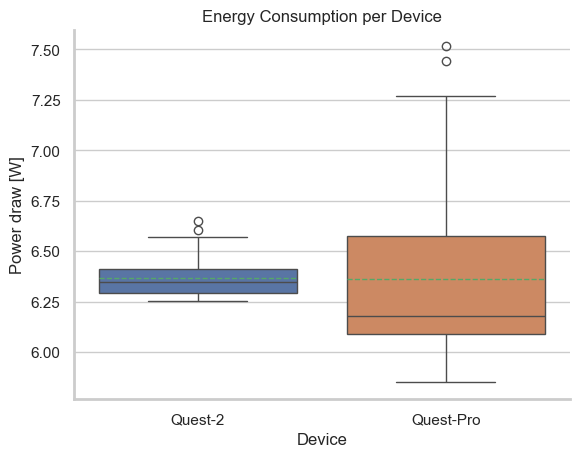

In [46]:
sns.boxplot(data=bm, x='device', y='Energy per Second (J/s)', showmeans=True, meanline=True, palette='deep')
plt.ylabel('Power draw [W]')
plt.xlabel('Device')
plt.title('Energy Consumption per Device')
plt.show()

### Energy Consumption per Device and App

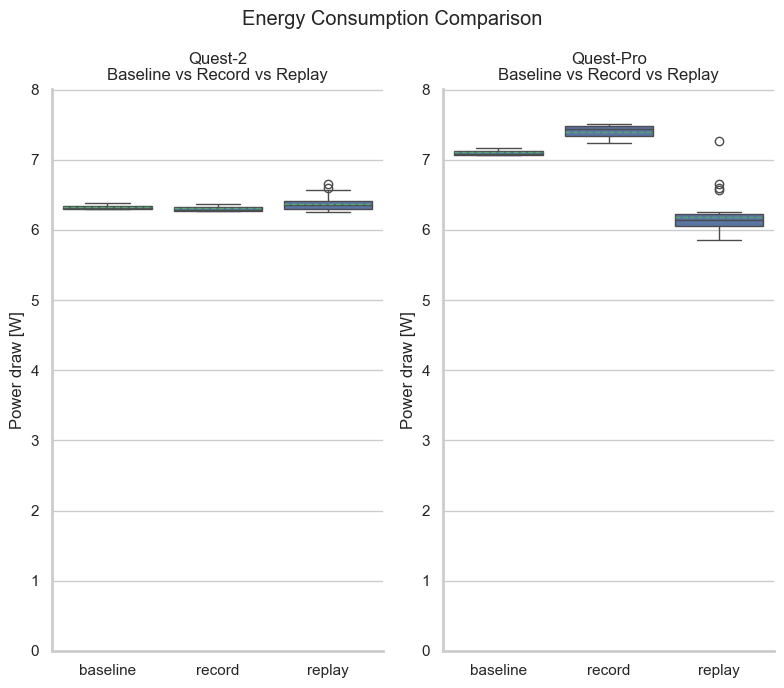

In [62]:
def plot_apps_by_device(df):
    unique_devices = df['device'].unique()[:2]
    num_devices = len(unique_devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(4*num_devices, 7))
    min_energy = df['Energy per Second (J/s)'].min() - 0.5
    max_energy = df['Energy per Second (J/s)'].max() +0.5
    
    for i, device in enumerate(unique_devices):
        ax = axes[i]
        sns.boxplot(data=df[df['device'] == device], x='is_record', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax)
        ax.set_ylabel('Power draw [W]')
        ax.set_xlabel('')
        ax.set_title(device + '\nBaseline vs Record vs Replay')

        ax.set_ylim(0, max_energy)
    
    fig.suptitle('Energy Consumption Comparison')
    plt.tight_layout()
    plt.show()

plot_apps_by_device(bm)

In [ ]:
bm = bm[bm['app'] != 'PistolWhip']

C:\Users\damla\AppData\Local\Temp\ipykernel_3328\1608249094.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_wireless'] == wireless], x='app_details', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax, palette='deep')
C:\Users\damla\AppData\Local\Temp\ipykernel_3328\1608249094.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_wireless'] == wireless], x='app_details', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax, palette='deep')


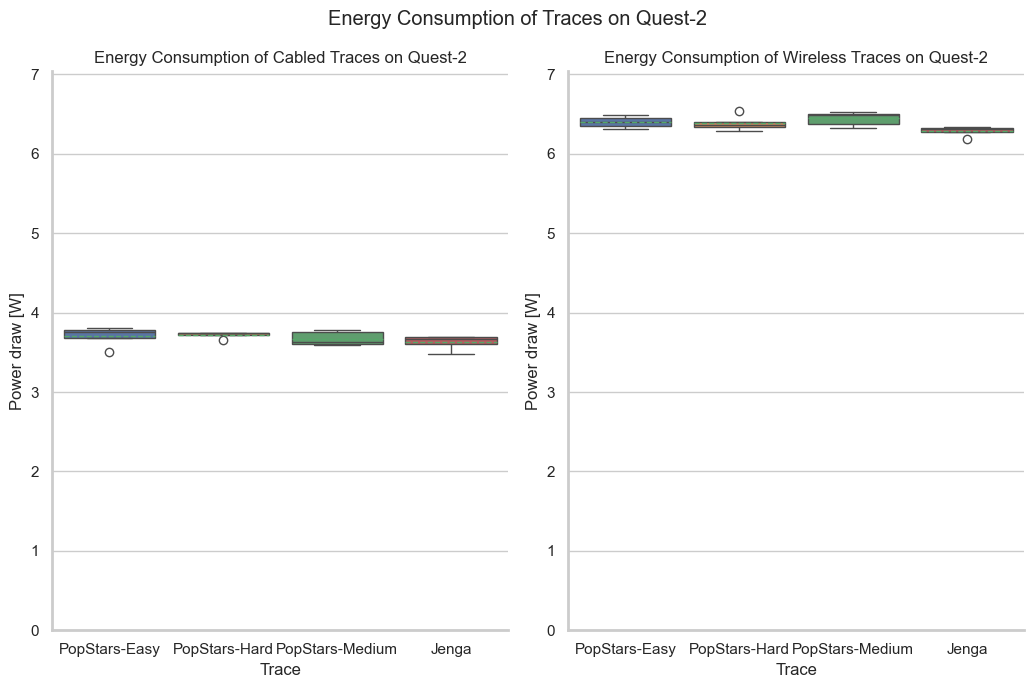

C:\Users\damla\AppData\Local\Temp\ipykernel_3328\1608249094.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_wireless'] == wireless], x='app_details', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax, palette='deep')
C:\Users\damla\AppData\Local\Temp\ipykernel_3328\1608249094.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_wireless'] == wireless], x='app_details', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax, palette='deep')


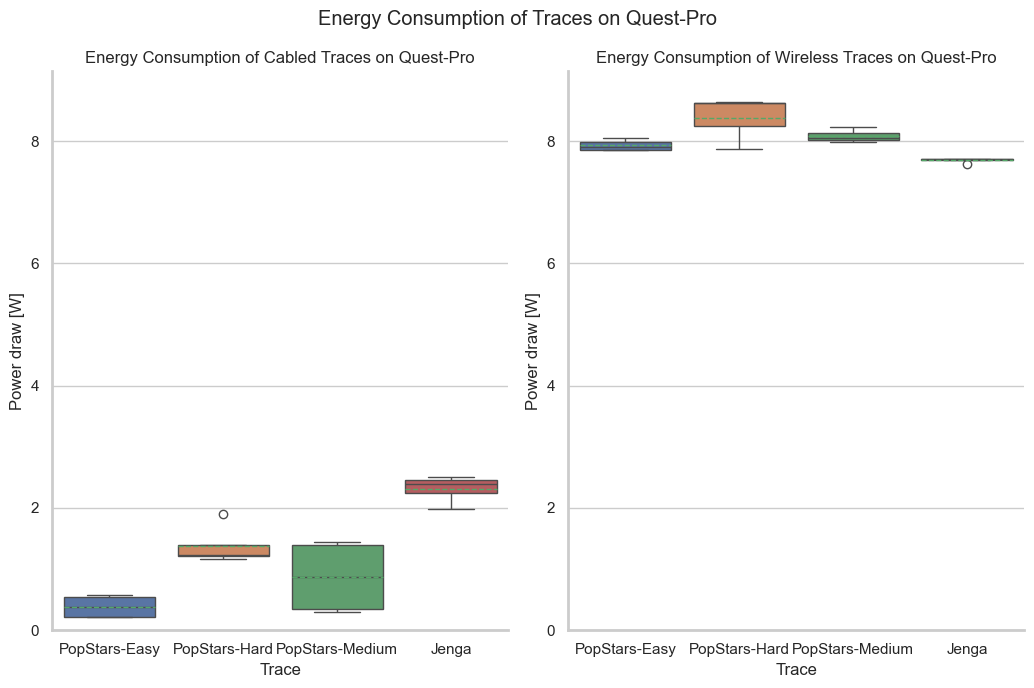

In [ ]:
def plot_traces_per_device(df, device):
    df = df[df['device'] == device]
    unique_apps = df['is_wireless'].unique()
    num_apps = len(unique_apps)
    fig, axes = plt.subplots(1, num_apps, figsize=(5.25*num_apps, 7))
    min_energy = df['Energy per Second (J/s)'].min() - 0.5
    max_energy = df['Energy per Second (J/s)'].max() + 0.5    
    
    for i, wireless in enumerate(unique_apps):
        ax = axes[i]
        sns.boxplot(data=df[df['is_wireless'] == wireless], x='app_details', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax, palette='deep')
        if wireless:
            ax.set_title('Energy Consumption of Wireless Traces on ' + device)
        else:
            ax.set_title('Energy Consumption of Cabled Traces on ' + device)
        ax.set_ylabel('Power draw [W]')
        ax.set_xlabel('Trace')

        ax.set_ylim(0, max_energy)
    fig.suptitle('Energy Consumption of Traces on ' + device)
    plt.tight_layout()
    plt.show()

plot_traces_per_device(bm, 'Quest-2')
plot_traces_per_device(bm, 'Quest-Pro')

.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.1\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.2\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.3\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.4\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.5\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.6\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.7\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.8\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.9\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars-Medium\replay0.1\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars

C:\Users\damla\AppData\Local\Temp\ipykernel_16864\487736687.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])


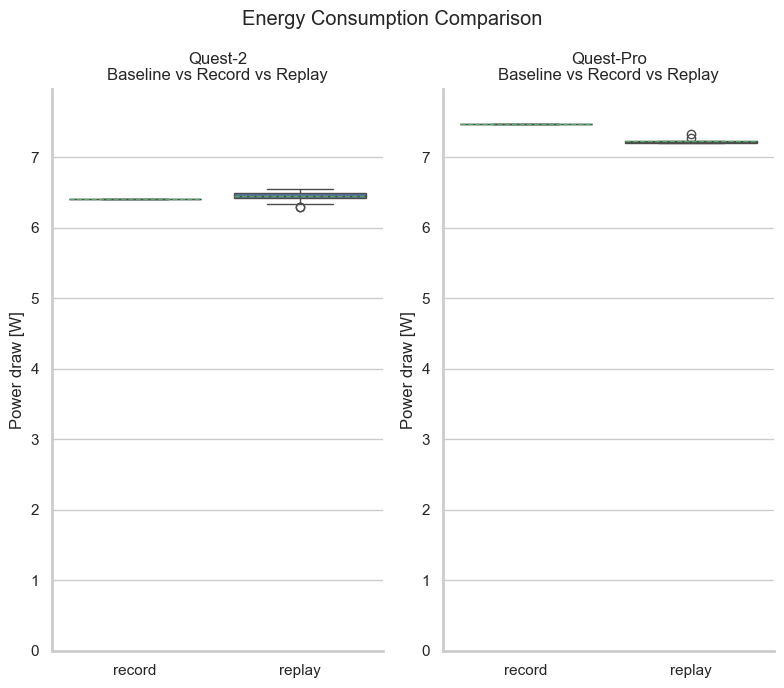

In [63]:
swap_bm = process_BM('swap-vr').reset_index(drop=True)
plot_apps_by_device(swap_bm)

## CPU GPU Validation

In [88]:
def get_cpu_gpu_data(path, folder_num):
    df = pd.DataFrame(columns=['device', 'app', 'is_record', 'repetition', 'timestamp_cpu', 'timestamp_gpu', 'cpu_usage', 'gpu_usage'])
    df['gpu_usage'] = pd.read_csv(path)['memoryUtil']
    df['timestamp_gpu'] = pd.read_csv(path)['timestamp']

    cpu_path = path.replace('host_gpu_metrics.log', 'host_sys_metrics.log')
    df['cpu_usage'] = pd.read_csv(cpu_path)['cpu.percent']
    df['timestamp_cpu'] = pd.read_csv(cpu_path)['timestamp']

    df['device'] = path.split('\\')[1 + folder_num]
    df['app'] = path.split('\\')[2 + folder_num].strip('-W')
    df['is_record'] = choose_repetition_type(path.split('\\')[4 + folder_num])
    df['repetition'] = set_run_number(path.split('\\')[4 + folder_num])
    
    return df


def process_cpu_gpu(folder):

    folder_num = len(folder.split('\\'))

    df_aggregated = pd.DataFrame(columns=['device', 'app', 'is_record', 'repetition', 'timestamp_cpu', 'timestamp_gpu', 'cpu_usage', 'gpu_usage'])
    for root, dirs, files in os.walk(".", topdown=False):
        for file in files:
            if (folder in root):
                if file == 'host_gpu_metrics.log':
                    path = os.path.join(root, file)
                    temp = get_cpu_gpu_data(path, folder_num)
                    df_aggregated = pd.concat([df_aggregated, temp])
                    
                # print(os.path.join(root, name))
                
    # normalized energy consumption for better comparison
    # df_aggregated['Energy per Second (J/s)'] = df_aggregated['energy(J)'] / df_aggregated['length(s)']
    df_aggregated['gpu_usage'] = df_aggregated['gpu_usage'] * 100
    return df_aggregated

wa = process_cpu_gpu('overhead-validation')

C:\Users\damla\AppData\Local\Temp\ipykernel_16864\2482431544.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, temp])


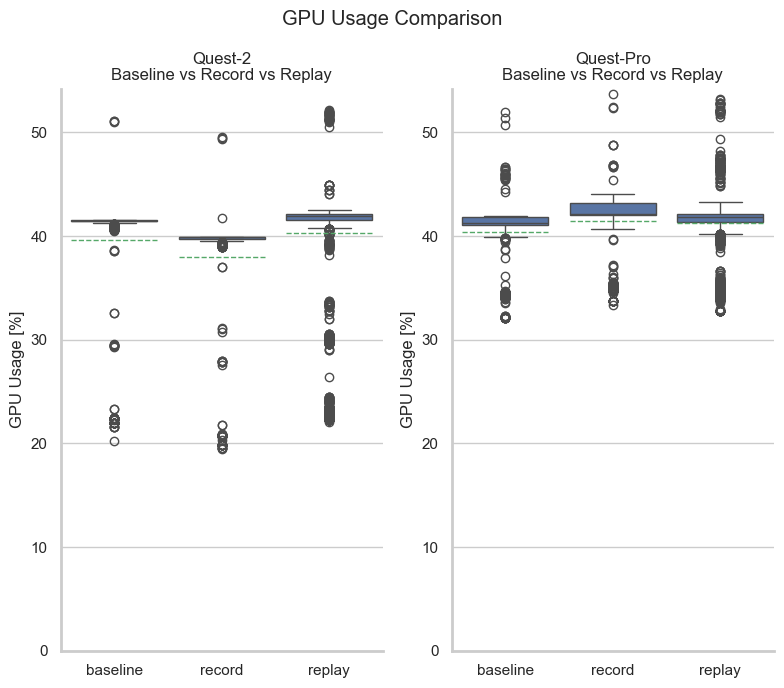

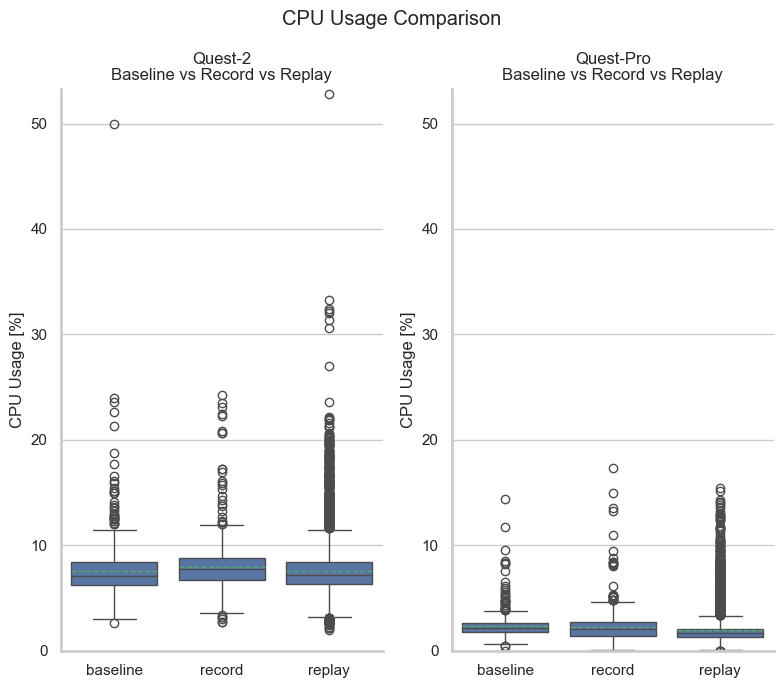

In [91]:
def plot_gpu_usage(df):
    unique_devices = df['device'].unique()[:2]
    num_devices = len(unique_devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(4*num_devices, 7))
    min_energy = df['gpu_usage'].min() - 0.5
    max_energy = df['gpu_usage'].max() +0.5
    
    for i, device in enumerate(unique_devices):
        ax = axes[i]
        sns.boxplot(data=df[df['device'] == device], x='is_record', y='gpu_usage', showmeans=True, meanline=True, ax=ax)
        ax.set_ylabel('GPU Usage [%]')
        ax.set_xlabel('')
        ax.set_title(device + '\nBaseline vs Record vs Replay')

        ax.set_ylim(0, max_energy)
    
    fig.suptitle('GPU Usage Comparison')
    plt.tight_layout()
    plt.show()


def plot_cpu_usage(df):
    unique_devices = df['device'].unique()[:2]
    num_devices = len(unique_devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(4*num_devices, 7))
    min_energy = df['cpu_usage'].min() - 0.5
    max_energy = df['cpu_usage'].max() +0.5
    
    for i, device in enumerate(unique_devices):
        ax = axes[i]
        sns.boxplot(data=df[df['device'] == device], x='is_record', y='cpu_usage', showmeans=True, meanline=True, ax=ax)
        ax.set_ylabel('CPU Usage [%]')
        ax.set_xlabel('')
        ax.set_title(device + '\nBaseline vs Record vs Replay')

        ax.set_ylim(0, max_energy)
    
    fig.suptitle('CPU Usage Comparison')
    plt.tight_layout()
    plt.show()

plot_gpu_usage(wa)
plot_cpu_usage(wa)

C:\Users\damla\AppData\Local\Temp\ipykernel_16864\2482431544.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, temp])


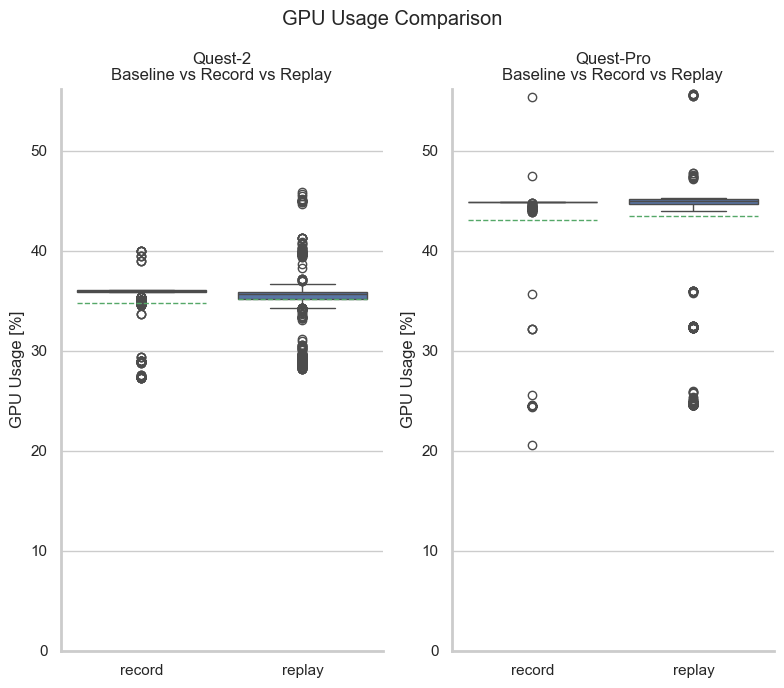

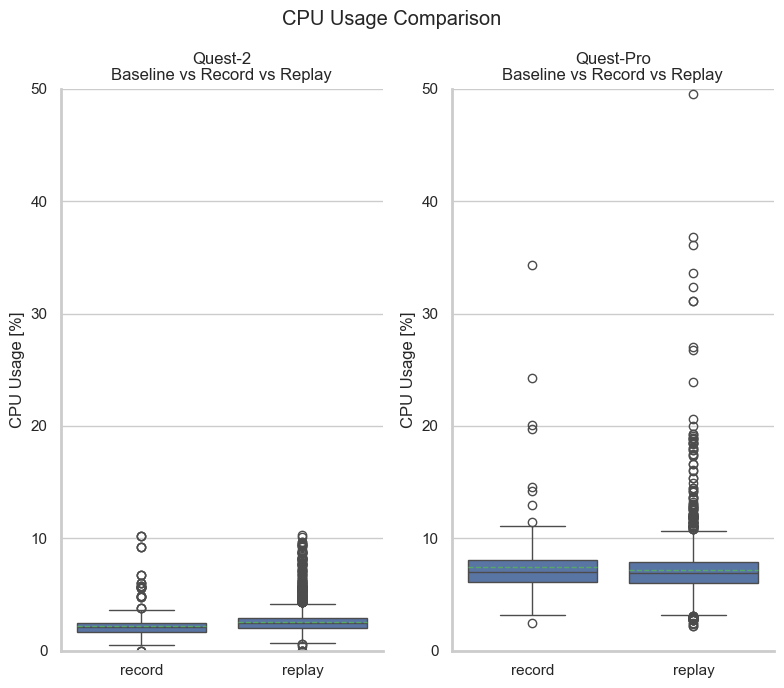

In [92]:
swap = process_cpu_gpu('swap-vr')
plot_gpu_usage(swap)
plot_cpu_usage(swap)